In [100]:
import pandas as pd
import numpy as np
from datasets import Dataset
import matplotlib.pyplot as plt

In [75]:
df = pd.read_csv('data/short_df.csv')
df.head()



,id,url,title,wiki_intro,generated_intro,title_len,wiki_intro_len,generated_intro_len,prompt,generated_text,prompt_tokens,generated_text_tokens
0,63064638,https://en.wikipedia.org/wiki/Sexhow%20railway...,Sexhow railway station,Sexhow railway station was a railway station b...,Sexhow railway station was a railway station l...,3,174,78,200 word wikipedia style introduction on 'Sexh...,"located in the town of Sexhow, on the Cumbria...",25,88
1,279621,https://en.wikipedia.org/wiki/Eti%C3%A4inen,Etiäinen,"In Finnish folklore, all places and things, an...","In Finnish folklore, all places and things, an...",1,187,80,200 word wikipedia style introduction on 'Etiä...,"animate or inanimate, have a spirit or ""etiäi...",26,101
2,287229,https://en.wikipedia.org/wiki/Inverse%20functi...,Inverse function theorem,"In mathematics, specifically differential calc...","In mathematics, specifically differential calc...",3,170,59,200 word wikipedia style introduction on 'Inve...,function theorem states that for every real-v...,26,65
3,26712375,https://en.wikipedia.org/wiki/Stepping%20on%20...,Stepping on Roses,is a Japanese shōjo manga series written and i...,is a Japanese shōjo manga series written and i...,3,335,121,200 word wikipedia style introduction on 'Step...,and illustrated by Maki Fujii. The series fol...,26,150
4,38894426,https://en.wikipedia.org/wiki/Rob%20Bradley,Rob Bradley,"Robert Milner ""Rob"" Bradley, Jr. (born August ...","Robert Milner ""Rob"" Bradley, Jr. (born August ...",2,170,136,200 word wikipedia style introduction on 'Rob ...,"29, 1973) is an American former professional ...",28,162


In [76]:
# create empty dataframe
generated_intro = pd.DataFrame(columns=['text'])

generated_intro['text'] = df['generated_intro']
generated_intro.insert(1, 'class', 1)

human_intro = pd.DataFrame(columns=['text'])

human_intro['text'] = df['wiki_intro']
human_intro.insert(1, 'class', 0)

df = pd.concat([generated_intro, human_intro])

df.head()


In [ ]:
dataset = Dataset.from_pandas(df)
dataset.column_names
dataset = dataset.remove_columns("__index_level_0__")


In [77]:
from datasets import DatasetDict

train_testvalid = dataset.train_test_split(test_size=0.1)
test_valid = train_testvalid['test'].train_test_split(test_size=0.5)
                             
datasets = DatasetDict({
    "train": train_testvalid["train"],
    "test": test_valid["test"],
    "valid": test_valid["train"]})

In [78]:
datasets

DatasetDict({
    train: Dataset({
        features: ['text', 'class'],
        num_rows: 1800
    })
    test: Dataset({
        features: ['text', 'class'],
        num_rows: 100
    })
    valid: Dataset({
        features: ['text', 'class'],
        num_rows: 100
    })
})

In [47]:
from transformers import DistilBertTokenizerFast

tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

In [48]:
def preprocess(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [49]:
tok_tezt = tokenizer('i will test this')

print(tok_tezt)

{'input_ids': [101, 1045, 2097, 3231, 2023, 102], 'attention_mask': [1, 1, 1, 1, 1, 1]}


In [50]:
tokens = tokenizer.convert_ids_to_tokens(tok_tezt.input_ids)
tokens

['[CLS]', 'i', 'will', 'test', 'this', '[SEP]']

The tokenizer has did following three things:

Lowercased the entire string
Added [CLS] and [SEP] special token to mark start and end of the string respectively.
The words 'Tokenizing' and 'NLP' has been split into two tokens because they are not common words.


In [79]:
df_encoded = datasets.map(preprocess, batched=True, batch_size=None)


Map:   0%|          | 0/1800 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [80]:
df_encoded.column_names

{'train': ['text', 'class', 'input_ids', 'attention_mask'],
 'test': ['text', 'class', 'input_ids', 'attention_mask'],
 'valid': ['text', 'class', 'input_ids', 'attention_mask']}

In [54]:
import torch
import torch.nn as nn

In [56]:
from transformers import AutoModel

model_ckpt = "distilbert-base-uncased"
device = torch.device("mps")
model = AutoModel.from_pretrained(model_ckpt).to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [57]:
text = "this is a test"
sample_inputs = tokenizer(text, return_tensors="pt")
print(f"Input tensor shape: {sample_inputs['input_ids'].size()}\n"
      f"Tokenized text: {tokenizer.convert_ids_to_tokens(sample_inputs['input_ids'][0])}")

Input tensor shape: torch.Size([1, 6])
Tokenized text: ['[CLS]', 'this', 'is', 'a', 'test', '[SEP]']


In [58]:
inputs = {k:v.to(device) for k,v in sample_inputs.items()}

with torch.no_grad():
    outputs = model(**inputs)
    print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]],
       device='mps:0'), hidden_states=None, attentions=None)


/opt/homebrew/Caskroom/miniconda/base/envs/ml/lib/python3.10/site-packages/torch/_tensor_str.py:115: UserWarning: MPS: nonzero op is supported natively starting from macOS 13.0. Falling back on CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/mps/operations/Indexing.mm:218.)
  nonzero_finite_vals = torch.masked_select(


In [59]:
outputs.last_hidden_state.shape

torch.Size([1, 6, 768])

In [60]:
outputs.last_hidden_state[:, 0].shape

torch.Size([1, 768])

In [83]:
print(type(df_encoded['train']['input_ids']))


<class 'torch.Tensor'>


In [61]:
def extract_hidden_states(batch):
    inputs = {k:v.to(device) for k, v in batch.items()
    if k in tokenizer.model_input_names}
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state

    return {"hidden state": last_hidden_state[:, 0].cpu().numpy()}

In [81]:
df_encoded.set_format("torch", columns=['input_ids', 'attention_mask', 'class'])

In [89]:
df_hidden = df_encoded.map(
    extract_hidden_states, batched=True, batch_size=2)

Map:   0%|          | 0/1800 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [92]:
df_hidden.column_names

{'train': ['text', 'class', 'input_ids', 'attention_mask', 'hidden state'],
 'test': ['text', 'class', 'input_ids', 'attention_mask', 'hidden state'],
 'valid': ['text', 'class', 'input_ids', 'attention_mask', 'hidden state']}

In [93]:

X_train = np.array(df_hidden["train"]["hidden state"])
X_valid = np.array(df_hidden["valid"]["hidden state"])
y_train = np.array(df_hidden["train"]["class"])
y_valid = np.array(df_hidden["valid"]["class"])
print(X_train.shape, X_valid.shape)

(1800, 768) (100, 768)


In [94]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

pca = PCA(n_components=2)

x_scaled = MinMaxScaler().fit_transform(X_train)
x_2d = pca.fit_transform(x_scaled)
x_2d.shape

(1800, 2)

In [95]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.94

In [96]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_pred, y_true, labels):
    cm = confusion_matrix(y_true, y_pred, normalize="true")
    _, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

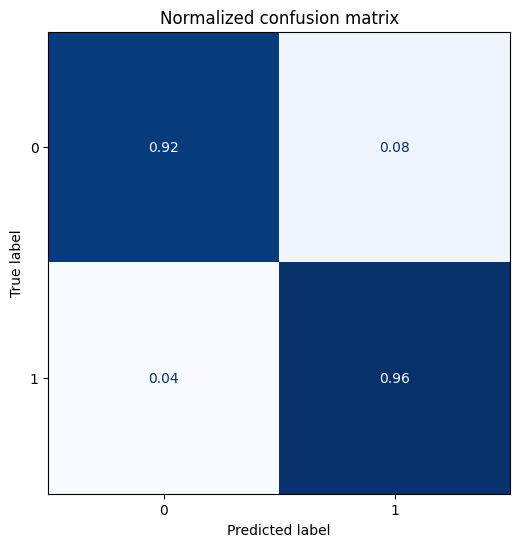

In [101]:
y_pred = lr_clf.predict(X_valid)
labels = (0,1)
plot_confusion_matrix(y_pred, y_valid, labels)

In [102]:
lr_clf.predict(X_valid[:5])

LogisticRegression(max_iter=3000)

In [123]:
def predict_text(text):
    inputs = tokenizer(text, return_tensors="pt")
    with torch.no_grad():
        last_hidden_state = model(**inputs.to(device)).last_hidden_state
    return lr_clf.predict_proba(last_hidden_state[:, 0].cpu().numpy())

In [128]:
predict_text("this is a test that human created")[0]

array([0.98878577, 0.01121423])

In [127]:
predict_text('animate or inanimate, have a spirit or "etiäinen" that lives there. Etiäinen can manifest in many forms, but is usually described as a kind, elderly woman with white hair. She is the guardian of natural places and often helps people in need. \n\nEtiäinen has been a part of Finnish culture for centuries and is still widely believed in today. Folklorists study etiäinen to understand Finnish traditions and how they have changed over time')

array([[0.27461305, 0.72538695]])